In [20]:
import matplotlib.pyplot as plt
from Objects.Simulation import Simulation
import numpy as np
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

In [21]:
def plot_one_record(record_zipped, dimension, x_timeline):
    keys = record_zipped.keys()
    if len(keys) <= 10:
        for key in keys:
            plt.plot(x_timeline, record_zipped[key][dimension], label = str(key))
    else:
        for key in keys:
            plt.plot(x_timeline, record_zipped[key][dimension])
    plt.legend(title="Vehicle ID")
    ylabelmap = {
        0:"Acceleration",
        1:"Speed",
        2:"Position",
        3:"Headway"
    }
    ylabel = ylabelmap[dimension]
    plt.ylabel(ylabel)
    plt.xlabel("Time (second)")
    plt.show()

In [22]:
def zip_records(records):
    record_zipped = {}
    for key in records.keys():
        record_zipped[key] = np.array(list(zip(*records[key].values())))
    return record_zipped

In [23]:
def plot_records(p):
    records = p.records
    x_timeline = np.array(list(records[0].keys()))
    x_timeline = x_timeline / 1000
    record_zipped = zip_records(records)
    for dim in range(4):
        plot_one_record(record_zipped, dim, x_timeline)
    
def cal_avg_delay(p):
    delays = []
    for car in p.platoon:
        if car.delay <0:
            raise Exception("Vehicle hasn't pass loc = 0 point.")
        delays.append(car.delay)
    return np.mean(delays), np.max(delays)

In [24]:
def cal_avg_avg_delay(times, number_vehicles, intended_speed):
    delays = []
    highest_delays = []
    for i in range(times):
        p = sim.run_gipps_simluation(n = number_vehicles, intend_speed = intended_speed, randomness = True)
        delays.append(cal_avg_delay(p)[0])
        highest_delays.append(cal_avg_delay(p)[1])
    return np.mean(delays), np.max(highest_delays)

In [25]:
simulation_time = 25 # seconds
number_vehicles = 5 # number of vehicles
intended_speed = 20 # intended speed / speed limit of the road
sim = Simulation(time = simulation_time)

Average delay is 11.554679100145957, the highest delay is 13.17362286147094


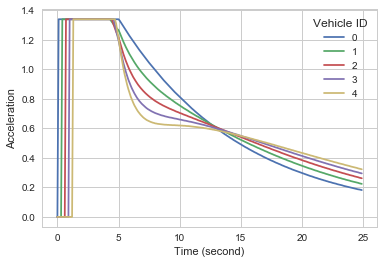

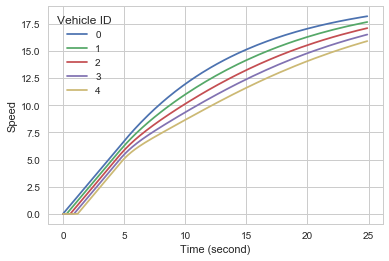

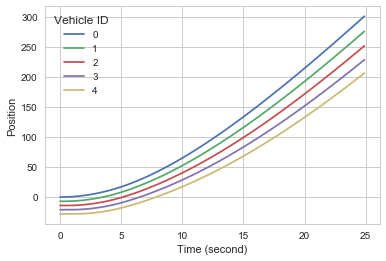

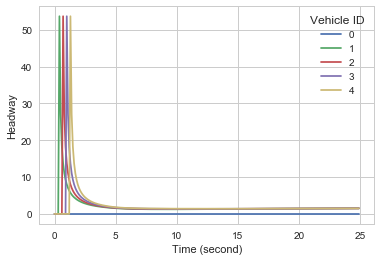

In [26]:
p = sim.run_cav_simluation(n = number_vehicles, intend_speed = intended_speed, ACDA=True)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(p)))
plot_records(p)

Average delay is 8.279854992044127, the highest delay is 8.785820188638649


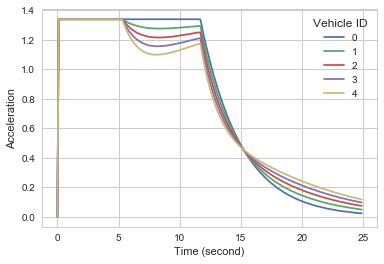

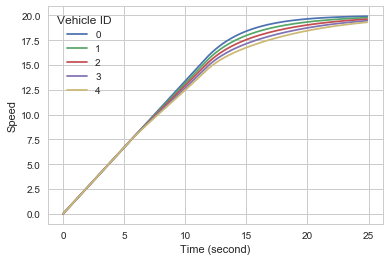

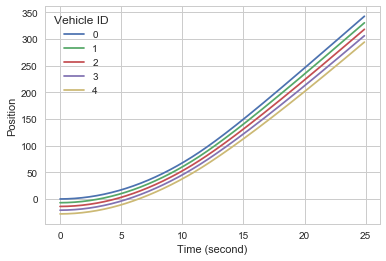

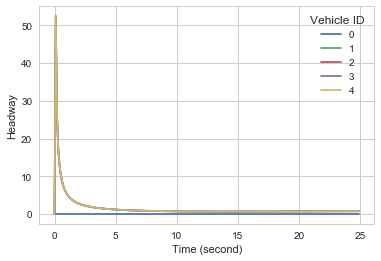

In [27]:
p = sim.run_cav_simluation(n = number_vehicles, intend_speed = intended_speed, ACDA=False)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(p)))
plot_records(p)

Average delay is 8.128097089675595, the highest delay is 8.503587307459668


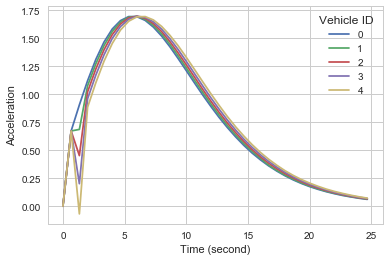

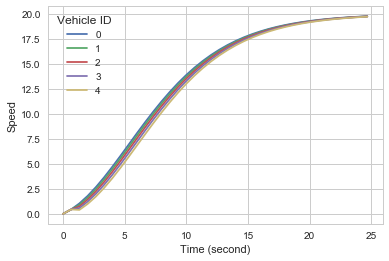

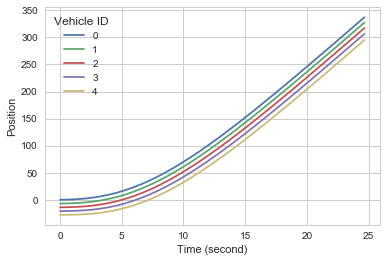

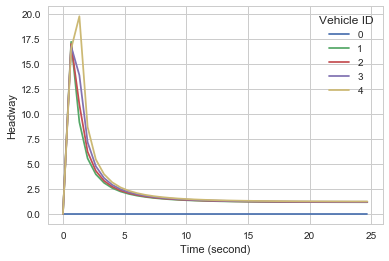

In [28]:
randomness = False # Gipps Model randomness
p = sim.run_gipps_simluation(n = number_vehicles, intend_speed = intended_speed, randomness = randomness)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(p)))
plot_records(p)